In [2]:
import os
import pandas as pd
import networkx as nx
from tqdm.autonotebook import tqdm
os.getcwd()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1668/4073993962.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


'/Users/mstudio/repository/research/cross-platform2'

Twitter

In [8]:
li=[]
for i in tqdm(os.listdir(r"/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/twitter_all")):
    if i.endswith('.csv'):
        data=pd.read_csv(r"/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/revise_and_revision/rr_toxicity_twitter/rr-toxicity-rr-"+i)
        li.append(data)

100%|██████████| 47/47 [01:19<00:00,  1.70s/it]


In [12]:
frame = pd.concat(li, axis=0, ignore_index=True)
frame.shape

(1558956, 11)

In [13]:
Twt=frame.loc[~frame['tweet'].str.contains('RT', case=True, na=False)]

In [14]:
Twt.shape

(370210, 11)

In [15]:
cross=pd.read_csv(r'/Users/mstudio/Library/CloudStorage/Box-Box/us_election_2020/Jay-toxicity/revise_and_revision/user_activity.csv')

In [16]:
cross.shape

(38798, 4)

In [17]:
most20=Twt[Twt['lower_username'].isin(cross.sort_values(by=['total'], ascending=False).head(20)['lower_username'])]

In [18]:
allmost=Twt[Twt['lower_username'].isin(cross.sort_values(by=['total'], ascending=False)['lower_username'])]

In [19]:
def build_edges(df):
    df['interact'] = df['tweet'].str.findall(r'(@[^\s]+)').str.join(' ').str.replace(':', '')
    edges=[]
    for idx, row in df.iterrows():
        if len(df['interact'].str.findall(r'(@[^\s]+)')[idx]) > 1:
            num=len(df['interact'].str.findall(r'(@[^\s]+)')[idx])
            for k in range(0, num):
                empty=[]
                empty.append(df['interact'].str.findall(r'(@[^\s]+)')[idx][k])
                edges.append((row['lower_username'], ''.join(empty)))
        elif len(df['interact'].str.findall(r'(@[^\s]+)')[idx]) == 0:
            continue
        elif len(df['interact'].str.findall(r'(@[^\s]+)')[idx]) == 1:
            edges.append((row['lower_username'], ''.join(df['interact'].str.findall(r'(@[^\s]+)')[idx])))
    edges_no_self=[]
    for i in edges:
        if i[0] != i[1]:
            edges_no_self.append((i[0], i[1].lstrip('@').lower()))
        else:
            pass
    return edges_no_self

In [20]:
import time
start_time = time.time()
edges=build_edges(most20)
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1668/866991499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interact'] = df['tweet'].str.findall(r'(@[^\s]+)').str.join(' ').str.replace(':', '')


--- 80.61816596984863 seconds ---


In [21]:
len(edges)

6688

In [22]:
node_names=set(most20['lower_username'])

In [24]:
G = nx.Graph()
G.add_nodes_from(node_names)
G.add_edges_from(edges)
# print(nx.info(G))

In [25]:
import time
start_time = time.time()
dicts={}
for i in tqdm(G.nodes):
    if i in Twt['lower_username'].unique(): #check if user id appears in the whole dataset
        dicts[i]='red' #parler
    else:
        dicts[i]='blue' #twitter
print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/1834 [00:00<?, ?it/s]

100%|██████████| 1834/1834 [00:26<00:00, 69.52it/s]

--- 26.383575201034546 seconds ---


In [26]:
len(dicts)

1834

In [27]:
nx.set_node_attributes(G, dicts, 'platform')

In [28]:
nx.set_node_attributes(G,nx.degree_centrality(G),name="degree_centrality")
centrality_df = pd.DataFrame([nx.get_node_attributes(G,'degree_centrality')], index=['degree_centrality'])
centrality_df = centrality_df.T

In [29]:
size_dict={}
for key in tqdm(nx.degree_centrality(G)):
    size_dict[key]=nx.degree_centrality(G)[key] * 200000 + 1000

100%|██████████| 1834/1834 [00:00<00:00, 3962.31it/s]


In [30]:
nx.set_node_attributes(G, size_dict, name="size")

In [31]:
G.nodes['teamtrump']

{'platform': 'red',
 'degree_centrality': 0.003273322422258592,
 'size': 1654.6644844517184}

In [32]:
G.nodes['nytimes']

{'platform': 'blue',
 'degree_centrality': 0.002182214948172395,
 'size': 1436.442989634479}

In [33]:
G.remove_nodes_from(list(nx.isolates(G)))

In [34]:
centrality=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
centrality.reset_index(inplace=True)
centrality=centrality.rename(columns={'index':'lower_username'})

In [35]:
centrality['size']=centrality["degree_centrality"] * 200000 + 1000

In [36]:
len(G.nodes)

1833

In [37]:
import time
start_time = time.time()
pos=nx.spring_layout(G)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.43192195892334 seconds ---


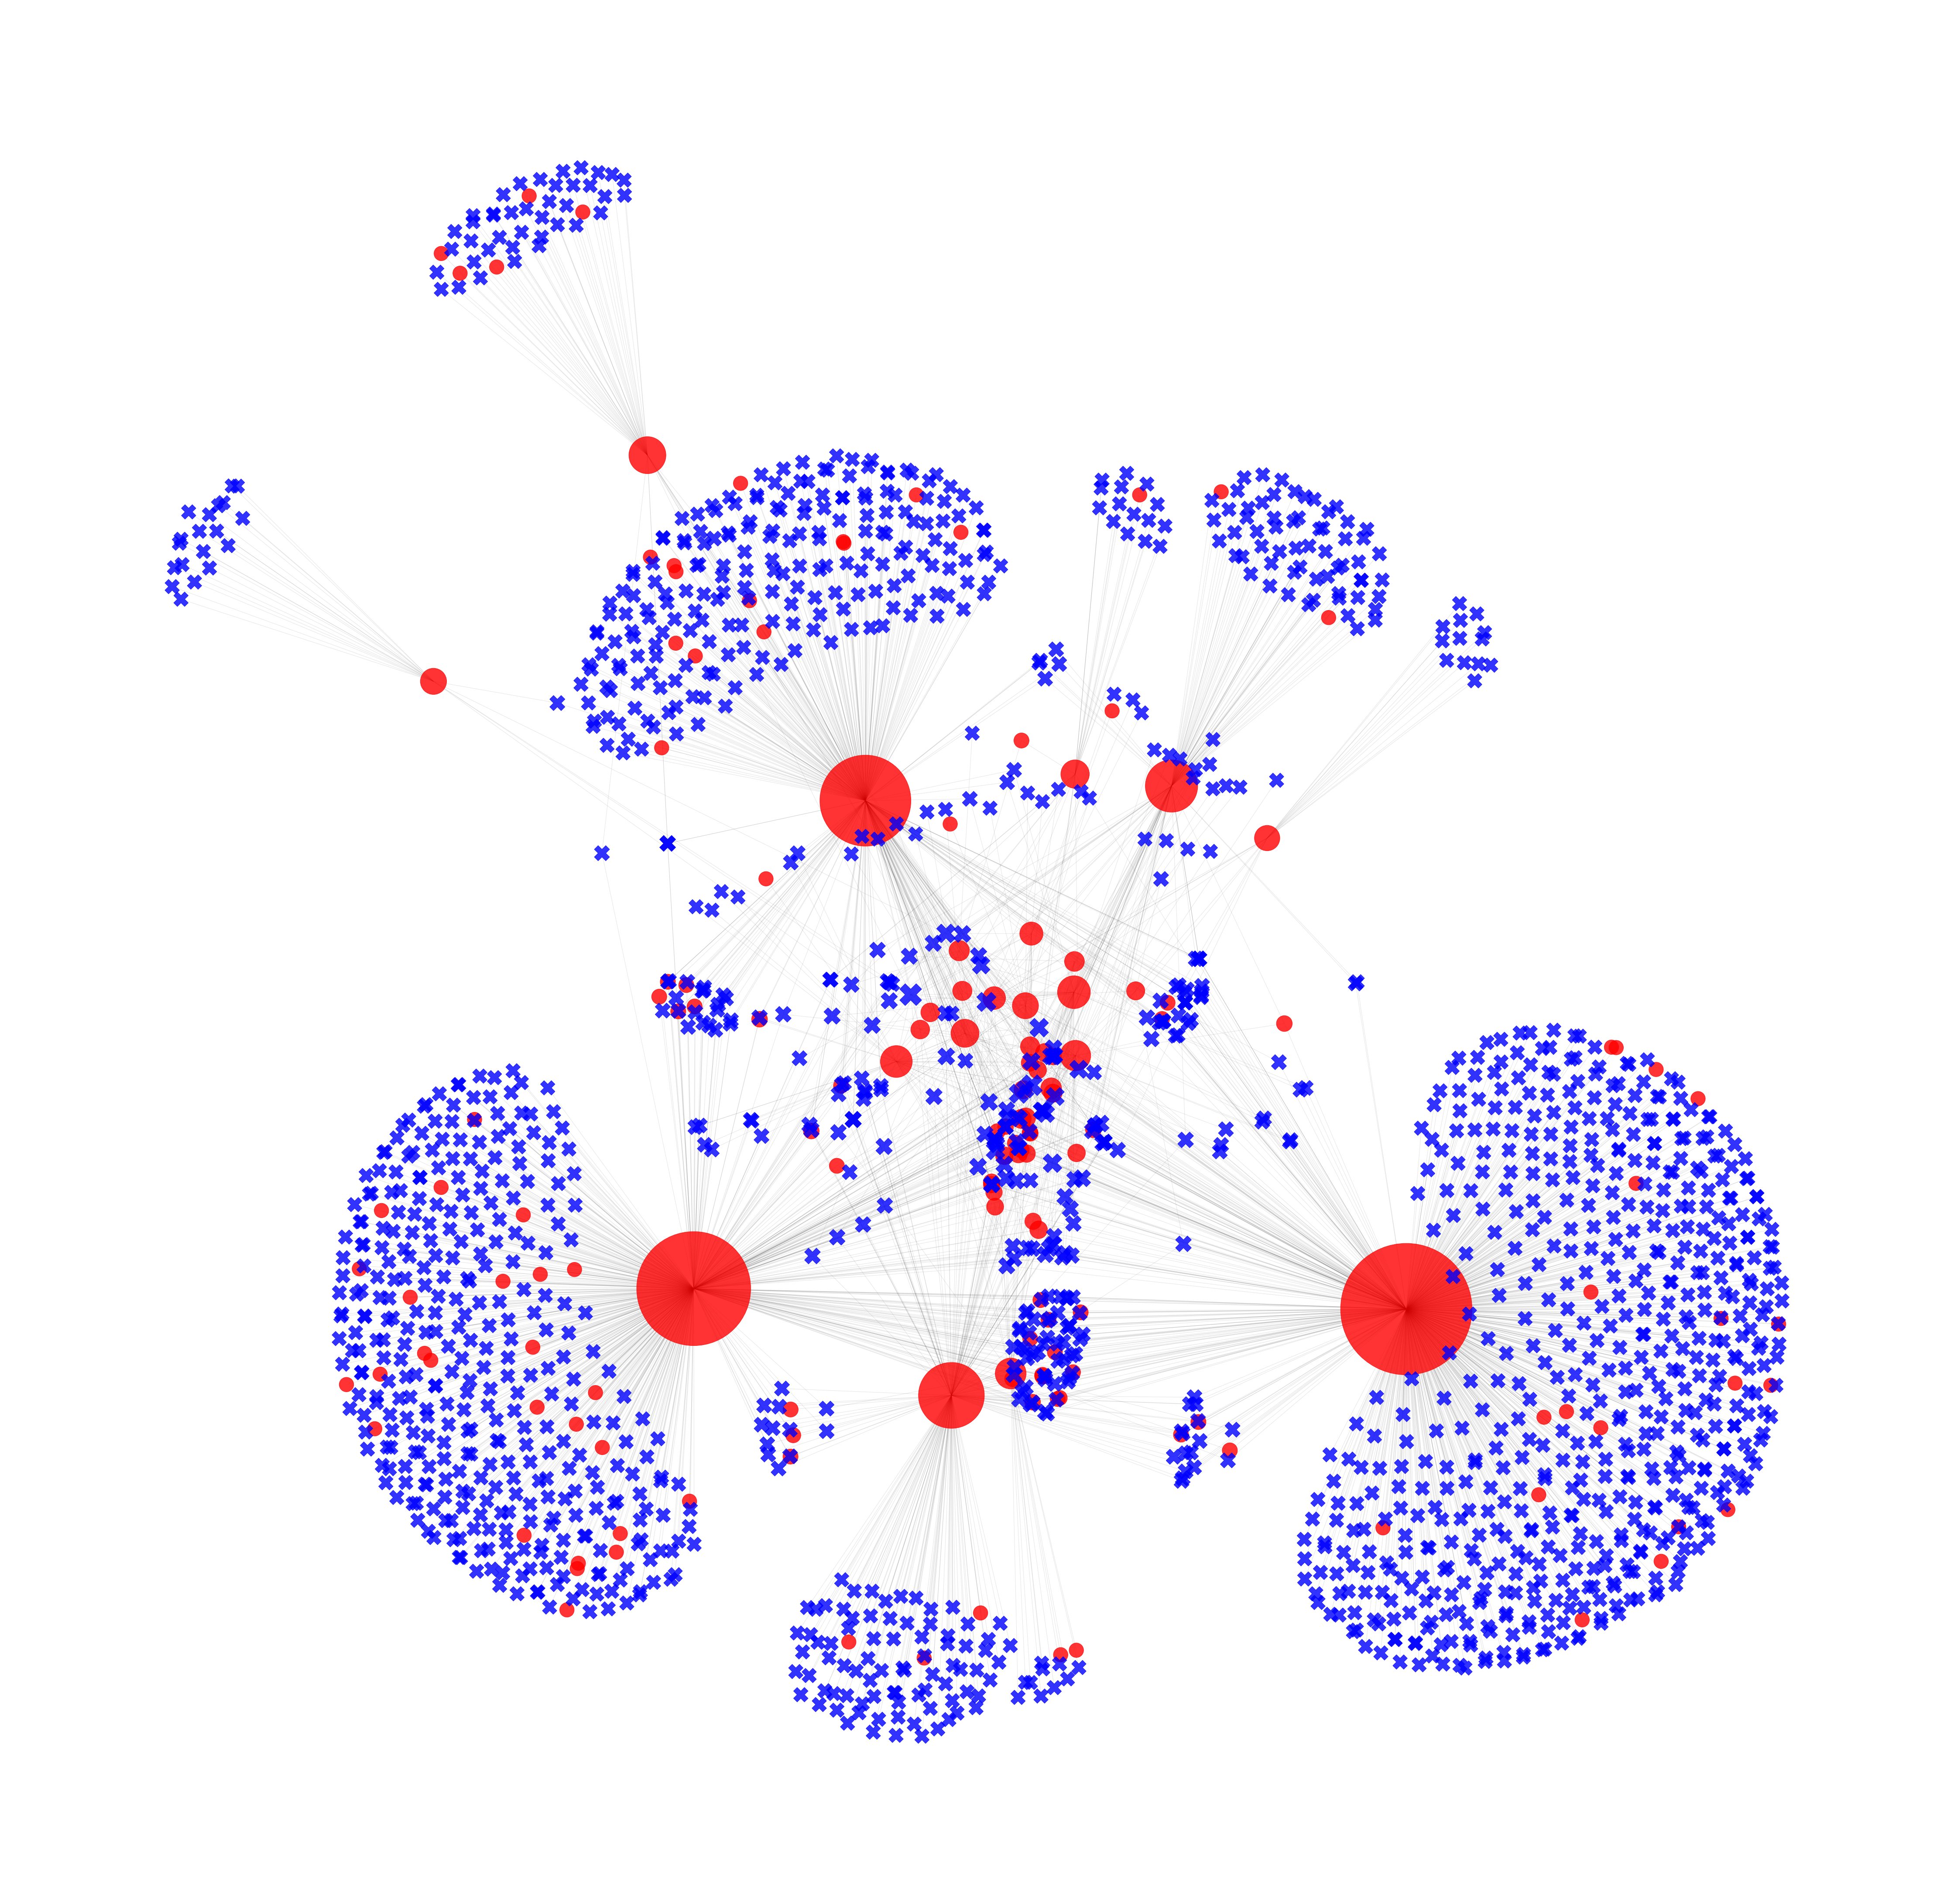

--- 3.959348678588867 seconds ---


In [93]:
import matplotlib.pyplot as plt
import time
start_time = time.time()
plt.figure(figsize=(80, 80))
plt.axis('off')

red_nodes = [n for (n,ty) in nx.get_node_attributes(G,'platform').items() if ty == 'red']
blue_nodes = [n for (n,ty) in nx.get_node_attributes(G,'platform').items() if ty == 'blue']

nx.draw_networkx_nodes(G, pos, nodelist=red_nodes, node_color='red', node_shape='o', node_size=centrality[centrality['platform']=='red']['size'], alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=blue_nodes, node_color='blue', node_shape='X', node_size=centrality[centrality['platform']=='blue']['size'], alpha=0.8)
# nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Spectral, node_color=nx.get_node_attributes(G, 'platform').values(), node_size=size_t.to_numpy(), alpha=0.8),# node_color=list(partition.values()), alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.1)
#nx.draw_networkx_labels(G, pos, font_size=20, font_family='monospace')
# node_colors = [G.nodes[n]['platform'] for n in G.nodes()]
# legend_elements=plt.Line2D([0], [0], marker='o', color='red', label='Red Nodes', markersize=10)
# legend_elements = [plt.Line2D([0], [0], marker='o', color=c, label=f'{c.capitalize()} Nodes', markersize=100) for c in set(node_colors)]
# plt.legend(handles=legend_elements, fontsize=100)
plt.savefig(r'C:\Users\jaihyun2\Box\us_election_2020\Jay-toxicity\revise_and_revision\RQ3rr_shape.pdf', bbox_inches='tight', dpi=500)
plt.show(G)
print("--- %s seconds ---" % (time.time() - start_time))

In [38]:
def ego_EI_idx(graph:G):
    EI_dic={}
    for k in G.nodes:
        external=0
        internal=0
        try:
            for i in G.edges(k):
                if G.nodes[i[1]]['platform'] == G.nodes[k]['platform']:
                    internal+=1
                elif G.nodes[i[1]]['platform'] != G.nodes[k]['platform']:
                    external+=1
        except ZeroDivisionError:
            pass
        EI_dic[k]=(abs(external)-abs(internal))/(abs(external)+abs(internal))
    nx.set_node_attributes(G, EI_dic, name="ei_idx")

In [39]:
ego_EI_idx(G)

In [40]:
ei_idx_df=pd.DataFrame.from_dict(nx.get_node_attributes(G, 'ei_idx'), orient='index')
ei_idx_df.reset_index(inplace=True)
ei_df=ei_idx_df.rename(columns={'index':'lower_username', 0:'ei_index'})

In [41]:
ei_df.to_csv('node_ei_index.csv')

In [112]:
centrality.merge(ei_df).to_csv(r'C:\Users\jaihyun2\Box\us_election_2020\Jay-toxicity\revise_and_revision\ei_df.csv')